In [84]:
#numerical stability
1000000000 + 0.000001 * 1000000 - 1000000000

1.0

In [24]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
      save = pickle.load(f)
      train_dataset = save['train_dataset']
      train_labels = save['train_labels']
      valid_dataset = save['valid_dataset']
      valid_labels = save['valid_labels']
      test_dataset = save['test_dataset']
      test_labels = save['test_labels']
      del save  # hint to help gc free up memory
      print('Training set', train_dataset.shape, train_labels.shape)
      print('Validation set', valid_dataset.shape, valid_labels.shape)
      print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


In [3]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
      dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
      # Map 2 to [0.0, 1.0, 0.0 ...], 3 to [0.0, 0.0, 1.0 ...]
      labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
      return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


Problem 1

Introduce and tune L2 regularization for both logistic and neural network models. 

Remember that L2 amounts to adding a penalty on the norm of the weights to the loss.

In TensorFlow, you can compute the L2 loss for a tensor t using nn.l2_loss(t). 

The right amount of regularization should improve your validation / test accuracy.

In [13]:
#first define the batch size
# I guess if want to use stochastic, must use batch
batch_size = 128

graph = tf.Graph()

with graph.as_default():
    
    #first should be input
    #placeholder should first define the type of the data
    tf_train_data = tf.placeholder(tf.float32,shape = (batch_size,image_size * image_size))
    tf_train_label = tf.placeholder(tf.float32,shape = (batch_size,num_labels))
    tf_valid_data = tf.constant(valid_dataset)
    tf_test_data = tf.constant(test_dataset)
    lamda_reg = tf.placeholder(tf.float32)
    
    #then define variable
    weight = tf.Variable(tf.truncated_normal([image_size*image_size, num_labels]))
    biases = tf.Variable(tf.zeros([num_labels]))
    
    #this part should be compute the content in each layer
    logit = tf.matmul(tf_train_data,weight) + biases
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logit,tf_train_label)) + lamda_reg * tf.nn.l2_loss(weight)
    
    #define the optimizer
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    # variable for display in the training proces
    # since the accuracy function is just here, here we only need to calculate the softmax(logit)
    train_predict = tf.nn.softmax(logit)
    valid_predict = tf.nn.softmax(tf.matmul(tf_valid_data,weight) + biases)
    test_predict = tf.nn.softmax(tf.matmul(tf_test_data,weight) + biases)

In [14]:
def accuracy(predictions, labels):
      return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
              / predictions.shape[0])

In [21]:
#first define step, I guess the step here is echo
steps = 3001

with tf.Session(graph = graph) as session:
    #initialize the variable first
    tf.initialize_all_variables().run()
    print("Initialized")

    for step in range(steps):
        # I guess offset is find where to begin with
        offset = (step * batch_size)% (train_labels.shape[0]-batch_size)
        batch_data = train_dataset[offset:(offset+batch_size),:]
        batch_label = train_labels[offset:(offset+batch_size),:]
        #feed_dict
        feed_dict = {tf_train_data:batch_data,tf_train_label:batch_label,lamda_reg:0.08}
        
        #session run
        _,l,prediction = session.run([optimizer,loss,train_predict],feed_dict = feed_dict)
        
        #print the info
        if (step%500 == 0):
            print ('Minibatch at step %d: %f'%(step,l))
            print("Minibatch accuracy: %.1f%%" % accuracy(prediction, batch_label))
            print("Validation accuracy: %.1f%%" % accuracy(
              valid_predict.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_predict.eval(), test_labels))

Initialized
Minibatch at step 0: 260.066925
Minibatch accuracy: 9.4%
Validation accuracy: 11.0%
Minibatch at step 500: 0.885657
Minibatch accuracy: 85.2%
Validation accuracy: 79.1%
Minibatch at step 1000: 1.061215
Minibatch accuracy: 75.8%
Validation accuracy: 78.9%
Minibatch at step 1500: 0.841596
Minibatch accuracy: 82.8%
Validation accuracy: 78.1%
Minibatch at step 2000: 0.956766
Minibatch accuracy: 81.2%
Validation accuracy: 75.9%
Minibatch at step 2500: 1.044013
Minibatch accuracy: 74.2%
Validation accuracy: 77.6%
Minibatch at step 3000: 1.054308
Minibatch accuracy: 78.1%
Validation accuracy: 78.7%
Test accuracy: 85.7%


In [22]:
# pow means 10**i
regul_val = [pow(10, i) for i in np.arange(-4, -2, 0.1)]
x = np.arange(-4, -2, 0.1)

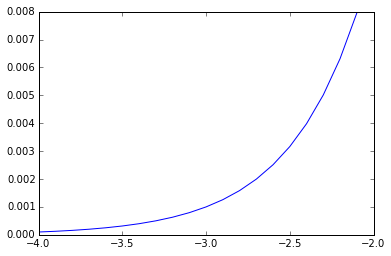

In [25]:
plt.figure()

plt.plot(x, regul_val)

In [41]:
steps = 3001
regul_val = [pow(10, i) for i in np.arange(-4, -2, 0.1)]
x =np.arange(-4, -2, 0.1)
result_test = []

for reg in regul_val:
    with tf.Session(graph = graph) as session:
        #initialize the variable first
        tf.initialize_all_variables().run()
        #print("Initialized")

        for step in range(steps):
            # I guess offset is find where to begin with
            offset = (step * batch_size)% (train_labels.shape[0]-batch_size)
            batch_data = train_dataset[offset:(offset+batch_size),:]
            batch_label = train_labels[offset:(offset+batch_size),:]
            #feed_dict
            feed_dict = {tf_train_data:batch_data,tf_train_label:batch_label,lamda_reg:reg}

            #session run
            _,l,prediction = session.run([optimizer,loss,train_predict],feed_dict = feed_dict)

            #print the info
            #if (step%500 == 0):
                #print ('Minibatch at step %d: %f'%(step,l))
                #print("Minibatch accuracy: %.1f%%" % accuracy(prediction, batch_label))
                #print("Validation accuracy: %.1f%%" % accuracy(
                  #valid_predict.eval(), valid_labels))
        accu_test = accuracy(test_predict.eval(), test_labels)
        result_test.append(accu_test)
        print("reg: %r : Test accuracy: %.1f%%" %(reg,accu_test) )

reg: 0.0001 : Test accuracy: 86.6%
reg: 0.00012589254117941674 : Test accuracy: 86.8%
reg: 0.00015848931924611142 : Test accuracy: 87.3%
reg: 0.00019952623149688809 : Test accuracy: 87.3%
reg: 0.00025118864315095823 : Test accuracy: 87.4%
reg: 0.00031622776601683826 : Test accuracy: 87.4%
reg: 0.00039810717055349773 : Test accuracy: 88.0%
reg: 0.00050118723362727296 : Test accuracy: 88.2%
reg: 0.00063095734448019429 : Test accuracy: 88.7%
reg: 0.00079432823472428294 : Test accuracy: 88.7%
reg: 0.001000000000000002 : Test accuracy: 89.0%
reg: 0.0012589254117941701 : Test accuracy: 89.1%
reg: 0.0015848931924611173 : Test accuracy: 89.1%
reg: 0.001995262314968885 : Test accuracy: 89.1%
reg: 0.0025118864315095872 : Test accuracy: 89.2%
reg: 0.0031622776601683889 : Test accuracy: 89.1%
reg: 0.0039810717055349856 : Test accuracy: 89.0%
reg: 0.0050118723362727402 : Test accuracy: 89.0%
reg: 0.0063095734448019554 : Test accuracy: 88.9%
reg: 0.0079432823472428467 : Test accuracy: 88.7%


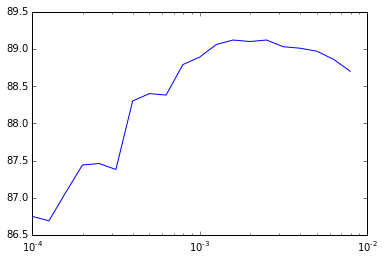

In [38]:
plt.figure()

plt.semilogx(regul_val,result_test)

In [44]:
##Add one layer netural network 
batch_size = 128
hidden_nodes = 1024
graph = tf.Graph()

with graph.as_default():
    
    #first should be input
    #placeholder should first define the type of the data
    tf_train_data = tf.placeholder(tf.float32,shape = (batch_size,image_size * image_size))
    tf_train_label = tf.placeholder(tf.float32,shape = (batch_size,num_labels))
    tf_valid_data = tf.constant(valid_dataset)
    tf_test_data = tf.constant(test_dataset)
    lamda_reg = tf.placeholder(tf.float32)
    
    #then define variable
    weight1 = tf.Variable(tf.truncated_normal([image_size*image_size, hidden_nodes]))
    biases1 = tf.Variable(tf.zeros([hidden_nodes]))
    weight2 = tf.Variable(tf.truncated_normal([hidden_nodes, num_labels]))
    biases2 = tf.Variable(tf.zeros([num_labels]))
    
    #this part should be compute the content in each layer
    layer1 = tf.matmul(tf_train_data,weight1) + biases1
    logit = tf.matmul(layer1,weight2) + biases2
    # notice that how to change the weight
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logit,tf_train_label)) + \
        lamda_reg * (tf.nn.l2_loss(weight1)+tf.nn.l2_loss(weight2))
    
    #define the optimizer
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    # variable for display in the training proces
    # since the accuracy function is just here, here we only need to calculate the softmax(logit)
    train_predict = tf.nn.softmax(logit)
    layer1_valid = tf.matmul(tf_valid_data,weight1) + biases1
    valid_predict = tf.nn.softmax(tf.matmul(layer1_valid,weight2) + biases2)
    layer2_valid = tf.matmul(tf_test_data,weight1) + biases1
    test_predict = tf.nn.softmax(tf.matmul(layer2_valid,weight2) + biases2)

In [51]:
steps = 5001

with tf.Session(graph = graph) as session:
    #initialize the variable first
    tf.initialize_all_variables().run()
    #print("Initialized")

    for step in range(steps):
        # I guess offset is find where to begin with
        offset = (step * batch_size)% (train_labels.shape[0]-batch_size)
        batch_data = train_dataset[offset:(offset+batch_size),:]
        batch_label = train_labels[offset:(offset+batch_size),:]
        #feed_dict
        feed_dict = {tf_train_data:batch_data,tf_train_label:batch_label,lamda_reg:0.0025}

        #session run
        _,l,prediction = session.run([optimizer,loss,train_predict],feed_dict = feed_dict)

        #print the info
        if (step%500 == 0):
            print ('Minibatch at step %d: %f'%(step,l))
            print("Minibatch accuracy: %.1f%%" % accuracy(prediction, batch_label))
            print("Validation accuracy: %.1f%%" % accuracy(
              valid_predict.eval(), valid_labels))
    accu_test = accuracy(test_predict.eval(), test_labels)
    result_test.append(accu_test)
    print("reg: %r : Test accuracy: %.1f%%" %(reg,accu_test) )

Minibatch at step 0: 788.691345
Minibatch accuracy: 8.6%
Validation accuracy: 30.1%
Minibatch at step 500: 208.850693
Minibatch accuracy: 75.0%
Validation accuracy: 69.7%
Minibatch at step 1000: 125.734802
Minibatch accuracy: 73.4%
Validation accuracy: 70.5%
Minibatch at step 1500: 68.923279
Minibatch accuracy: 76.6%
Validation accuracy: 71.2%
Minibatch at step 2000: 42.143120
Minibatch accuracy: 75.0%
Validation accuracy: 72.2%
Minibatch at step 2500: 25.308464
Minibatch accuracy: 64.1%
Validation accuracy: 69.7%
Minibatch at step 3000: 15.000704
Minibatch accuracy: 78.1%
Validation accuracy: 77.5%
Minibatch at step 3500: 9.183514
Minibatch accuracy: 76.6%
Validation accuracy: 77.0%
Minibatch at step 4000: 5.685534
Minibatch accuracy: 82.0%
Validation accuracy: 79.6%
Minibatch at step 4500: 3.772083
Minibatch accuracy: 82.8%
Validation accuracy: 80.4%
Minibatch at step 5000: 2.437489
Minibatch accuracy: 82.8%
Validation accuracy: 80.3%
reg: 0.00012589254117941674 : Test accuracy: 87.1

In [53]:
for reg in regul_val:
    with tf.Session(graph = graph) as session:
        #initialize the variable first
        tf.initialize_all_variables().run()
        #print("Initialized")

        for step in range(steps):
            # I guess offset is find where to begin with
            offset = (step * batch_size)% (train_labels.shape[0]-batch_size)
            batch_data = train_dataset[offset:(offset+batch_size),:]
            batch_label = train_labels[offset:(offset+batch_size),:]
            #feed_dict
            feed_dict = {tf_train_data:batch_data,tf_train_label:batch_label,lamda_reg:reg}

            #session run
            _,l,prediction = session.run([optimizer,loss,train_predict],feed_dict = feed_dict)

            #print the info
#             if (step%500 == 0):
#                 print ('Minibatch at step %d: %f'%(step,l))
#                 print("Minibatch accuracy: %.1f%%" % accuracy(prediction, batch_label))
#                 print("Validation accuracy: %.1f%%" % accuracy(
#                   valid_predict.eval(), valid_labels))
        accu_test = accuracy(test_predict.eval(), test_labels)
        result_test.append(accu_test)
        print("reg: %r : Test accuracy: %.1f%%" %(reg,accu_test) )

reg: 0.0001 : Test accuracy: 82.2%
reg: 0.00012589254117941674 : Test accuracy: 81.6%
reg: 0.00015848931924611142 : Test accuracy: 75.8%
reg: 0.00019952623149688809 : Test accuracy: 78.4%
reg: 0.00025118864315095823 : Test accuracy: 76.1%
reg: 0.00031622776601683826 : Test accuracy: 80.3%
reg: 0.00039810717055349773 : Test accuracy: 77.1%
reg: 0.00050118723362727296 : Test accuracy: 78.8%
reg: 0.00063095734448019429 : Test accuracy: 81.8%
reg: 0.00079432823472428294 : Test accuracy: 85.6%
reg: 0.001000000000000002 : Test accuracy: 87.1%
reg: 0.0012589254117941701 : Test accuracy: 87.6%
reg: 0.0015848931924611173 : Test accuracy: 87.9%
reg: 0.001995262314968885 : Test accuracy: 88.0%
reg: 0.0025118864315095872 : Test accuracy: 88.0%
reg: 0.0031622776601683889 : Test accuracy: 87.9%
reg: 0.0039810717055349856 : Test accuracy: 87.7%
reg: 0.0050118723362727402 : Test accuracy: 87.6%
reg: 0.0063095734448019554 : Test accuracy: 87.5%
reg: 0.0079432823472428467 : Test accuracy: 87.3%


In [60]:
##Add one layer netural network 
batch_size = 128
hidden_nodes = 1024
graph = tf.Graph()

with graph.as_default():
    
    #first should be input
    #placeholder should first define the type of the data
    tf_train_data = tf.placeholder(tf.float32,shape = (batch_size,image_size * image_size))
    tf_train_label = tf.placeholder(tf.float32,shape = (batch_size,num_labels))
    tf_valid_data = tf.constant(valid_dataset)
    tf_test_data = tf.constant(test_dataset)
    lamda_reg = tf.placeholder(tf.float32)
    
    #then define variable
    weight1 = tf.Variable(tf.truncated_normal([image_size*image_size, hidden_nodes]))
    biases1 = tf.Variable(tf.zeros([hidden_nodes]))
    weight2 = tf.Variable(tf.truncated_normal([hidden_nodes, num_labels]))
    biases2 = tf.Variable(tf.zeros([num_labels]))
    
    #this part should be compute the content in each layer
    layer1 = tf.nn.relu(tf.matmul(tf_train_data,weight1) + biases1)
    drop1 = tf.nn.dropout(layer1,0.5)
    logit = tf.matmul(drop1,weight2) + biases2
    # notice that how to change the weight
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logit,tf_train_label)) + \
        lamda_reg * (tf.nn.l2_loss(weight1)+tf.nn.l2_loss(weight2))
    
    #define the optimizer
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    # variable for display in the training proces
    # since the accuracy function is just here, here we only need to calculate the softmax(logit)
    train_predict = tf.nn.softmax(logit)
    layer1_valid = tf.nn.relu(tf.matmul(tf_valid_data,weight1) + biases1)
    valid_predict = tf.nn.softmax(tf.matmul(layer1_valid,weight2) + biases2)
    layer1_test = tf.nn.relu(tf.matmul(tf_test_data,weight1) + biases1)
    test_predict = tf.nn.softmax(tf.matmul(layer1_test,weight2) + biases2)

In [61]:
regul_val = [pow(10, i) for i in np.arange(-4, -2, 0.1)]

for reg in regul_val:
    with tf.Session(graph = graph) as session:
        #initialize the variable first
        tf.initialize_all_variables().run()
        #print("Initialized")

        for step in range(steps):
            # I guess offset is find where to begin with
            offset = (step * batch_size)% (train_labels.shape[0]-batch_size)
            batch_data = train_dataset[offset:(offset+batch_size),:]
            batch_label = train_labels[offset:(offset+batch_size),:]
            #feed_dict
            feed_dict = {tf_train_data:batch_data,tf_train_label:batch_label,lamda_reg:reg}

            #session run
            _,l,prediction = session.run([optimizer,loss,train_predict],feed_dict = feed_dict)

            #print the info
#             if (step%500 == 0):
#                 print ('Minibatch at step %d: %f'%(step,l))
#                 print("Minibatch accuracy: %.1f%%" % accuracy(prediction, batch_label))
#                 print("Validation accuracy: %.1f%%" % accuracy(
#                   valid_predict.eval(), valid_labels))
        accu_test = accuracy(test_predict.eval(), test_labels)
        result_test.append(accu_test)
        print("reg: %r : Test accuracy: %.1f%%" %(reg,accu_test) )

reg: 0.001 : Test accuracy: 92.9%
reg: 0.0012589254117941675 : Test accuracy: 93.0%
reg: 0.0015848931924611141 : Test accuracy: 92.8%
reg: 0.0019952623149688807 : Test accuracy: 92.6%
reg: 0.002511886431509582 : Test accuracy: 92.2%
reg: 0.0031622776601683824 : Test accuracy: 91.7%
reg: 0.0039810717055349778 : Test accuracy: 91.5%
reg: 0.0050118723362727298 : Test accuracy: 91.0%


KeyboardInterrupt: 

## add learnig rate decay and more laryers

In [71]:
##Add one layer netural network 
## 
batch_size = 128
hidden_nodes1 = 1024
hidden_nodes2 = 512
hidden_nodes3 = 256
hidden_nodes4 = 128

graph = tf.Graph()
starter_learning_rate = 0.5

with graph.as_default():
    
    #first should be input
    #placeholder should first define the type of the data
    tf_train_data = tf.placeholder(tf.float32,shape = (batch_size,image_size * image_size))
    tf_train_label = tf.placeholder(tf.float32,shape = (batch_size,num_labels))
    tf_valid_data = tf.constant(valid_dataset)
    tf_test_data = tf.constant(test_dataset)
    lamda_reg = tf.placeholder(tf.float32)
    # do not forget gobal step if need learning rate decay
    global_step = tf.Variable(0,trainable=False)
    
    
    #then define variable
    weight1 = tf.Variable(tf.truncated_normal([image_size*image_size, hidden_nodes1], stddev=np.sqrt(2.0 / hidden_nodes1)))
    biases1 = tf.Variable(tf.zeros([hidden_nodes1]))
    weight2 = tf.Variable(tf.truncated_normal([hidden_nodes1, hidden_nodes2], stddev=np.sqrt(2.0 / hidden_nodes2)))
    biases2 = tf.Variable(tf.zeros([hidden_nodes2]))
    weight3 = tf.Variable(tf.truncated_normal([hidden_nodes2, hidden_nodes3], stddev=np.sqrt(2.0 / hidden_nodes3)))
    biases3 = tf.Variable(tf.zeros([hidden_nodes3]))
    weight4 = tf.Variable(tf.truncated_normal([hidden_nodes3, num_labels], stddev=np.sqrt(2.0 / hidden_nodes4)))
    biases4 = tf.Variable(tf.zeros([num_labels]))
    
    
    
    
    #this part should be compute the content in each layer
    layer1 = tf.nn.relu(tf.matmul(tf_train_data,weight1) + biases1)
    drop1 = tf.nn.dropout(layer1,0.5)
    layer2 = tf.nn.relu(tf.matmul(drop1,weight2) + biases2)
    drop2 = tf.nn.dropout(layer2,0.5)
    layer3 = tf.nn.relu(tf.matmul(drop2,weight3) + biases3)
    drop3 = tf.nn.dropout(layer3,0.5)
    logit = tf.matmul(drop3,weight4) + biases4
    
    
    # notice that how to change the weight
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logit,tf_train_label)) + \
        lamda_reg * (tf.nn.l2_loss(weight1)+tf.nn.l2_loss(weight2)+tf.nn.l2_loss(weight3)+tf.nn.l2_loss(weight4))
    
    #define the optimizer
    #if need learning rate decay, use golbal_step here
    learning_rate_decay = tf.train.exponential_decay(starter_learning_rate,global_step,1000,0.7,staircase = True)
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss,global_step = global_step)
    
    # variable for display in the training proces
    # since the accuracy function is just here, here we only need to calculate the softmax(logit)
    train_predict = tf.nn.softmax(logit)
    
    layer1_valid = tf.nn.relu(tf.matmul(tf_valid_data,weight1) + biases1)
    layer2_valid = tf.nn.relu(tf.matmul(layer1_valid,weight2) + biases2)
    layer3_valid = tf.nn.relu(tf.matmul(layer2_valid,weight3) + biases3)
    valid_predict = tf.nn.softmax(tf.matmul(layer3_valid,weight4) + biases4)
    
    layer1_test = tf.nn.relu(tf.matmul(tf_test_data,weight1) + biases1)
    layer2_test = tf.nn.relu(tf.matmul(layer1_test,weight2) + biases2)
    layer3_test = tf.nn.relu(tf.matmul(layer2_test,weight3) + biases3)
    test_predict = tf.nn.softmax(tf.matmul(layer3_test,weight4) + biases4)

In [72]:
regul_val = [pow(10, i) for i in np.arange(-4, -2, 0.1)]


with tf.Session(graph = graph) as session:
    #initialize the variable first
    tf.initialize_all_variables().run()
    #print("Initialized")

    for step in range(steps):
        # I guess offset is find where to begin with
        offset = (step * batch_size)% (train_labels.shape[0]-batch_size)
        batch_data = train_dataset[offset:(offset+batch_size),:]
        batch_label = train_labels[offset:(offset+batch_size),:]
        #feed_dict
        feed_dict = {tf_train_data:batch_data,tf_train_label:batch_label,lamda_reg:0.002}

        #session run
        _,l,prediction = session.run([optimizer,loss,train_predict],feed_dict = feed_dict)

        #print the info
        if (step%500 == 0):
            print ('Minibatch at step %d: %f'%(step,l))
            print("Minibatch accuracy: %.1f%%" % accuracy(prediction, batch_label))
            print("Validation accuracy: %.1f%%" % accuracy(
              valid_predict.eval(), valid_labels))
    accu_test = accuracy(test_predict.eval(), test_labels)
    result_test.append(accu_test)
    print("step: %r : Test accuracy: %.1f%%" %(step,accu_test) )

Minibatch at step 0: 8.701390
Minibatch accuracy: 10.9%
Validation accuracy: 15.5%
Minibatch at step 500: 2.026393
Minibatch accuracy: 84.4%
Validation accuracy: 83.8%
Minibatch at step 1000: 1.258628
Minibatch accuracy: 83.6%
Validation accuracy: 84.4%
Minibatch at step 1500: 0.770765
Minibatch accuracy: 89.8%
Validation accuracy: 85.0%
Minibatch at step 2000: 0.623457
Minibatch accuracy: 90.6%
Validation accuracy: 85.5%
Minibatch at step 2500: 0.667017
Minibatch accuracy: 84.4%
Validation accuracy: 85.3%
Minibatch at step 3000: 0.689972
Minibatch accuracy: 85.2%
Validation accuracy: 85.7%
Minibatch at step 3500: 0.666136
Minibatch accuracy: 84.4%
Validation accuracy: 85.9%
Minibatch at step 4000: 0.650457
Minibatch accuracy: 87.5%
Validation accuracy: 85.7%
Minibatch at step 4500: 0.705120
Minibatch accuracy: 85.9%
Validation accuracy: 85.3%
Minibatch at step 5000: 0.774252
Minibatch accuracy: 84.4%
Validation accuracy: 86.2%
step: 5000 : Test accuracy: 92.6%


In [81]:
##Add one layer netural network 
## 
batch_size = 128
hidden_nodes1 = 1024
hidden_nodes2 = 512
hidden_nodes3 = 256
hidden_nodes4 = 128

graph = tf.Graph()
starter_learning_rate = 0.5

with graph.as_default():
    
    #first should be input
    #placeholder should first define the type of the data
    tf_train_data = tf.placeholder(tf.float32,shape = (batch_size,image_size * image_size))
    tf_train_label = tf.placeholder(tf.float32,shape = (batch_size,num_labels))
    tf_valid_data = tf.constant(valid_dataset)
    tf_test_data = tf.constant(test_dataset)
    lamda_reg = tf.placeholder(tf.float32)
    # do not forget gobal step if need learning rate decay
    global_step = tf.Variable(0,trainable=False)
    
    
    #then define variable
    weight1 = tf.Variable(tf.truncated_normal([image_size*image_size, hidden_nodes1], stddev=np.sqrt(2.0 / hidden_nodes1)))
    biases1 = tf.Variable(tf.zeros([hidden_nodes1]))
    weight2 = tf.Variable(tf.truncated_normal([hidden_nodes1, hidden_nodes2], stddev=np.sqrt(2.0 / hidden_nodes2)))
    biases2 = tf.Variable(tf.zeros([hidden_nodes2]))
    weight3 = tf.Variable(tf.truncated_normal([hidden_nodes2, hidden_nodes3], stddev=np.sqrt(2.0 / hidden_nodes3)))
    biases3 = tf.Variable(tf.zeros([hidden_nodes3]))
    weight4 = tf.Variable(tf.truncated_normal([hidden_nodes3, num_labels], stddev=np.sqrt(2.0 / hidden_nodes4)))
    biases4 = tf.Variable(tf.zeros([num_labels]))
    
    
    
    
    #this part should be compute the content in each layer
    layer1 = tf.nn.relu(tf.matmul(tf_train_data,weight1) + biases1)
    drop1 = tf.nn.dropout(layer1,0.5)
    layer2 = tf.nn.relu(tf.matmul(drop1,weight2) + biases2)
    drop2 = tf.nn.dropout(layer2,0.5)
    layer3 = tf.nn.relu(tf.matmul(drop2,weight3) + biases3)
    drop3 = tf.nn.dropout(layer3,0.5)
    logit = tf.matmul(drop3,weight4) + biases4
    
    
    # notice that how to change the weight
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logit,tf_train_label)) + \
        lamda_reg * (tf.nn.l2_loss(weight1)+tf.nn.l2_loss(weight2)+tf.nn.l2_loss(weight3)+tf.nn.l2_loss(weight4))
    
    #define the optimizer
    #if need learning rate decay, use golbal_step here
    learning_rate_decay = tf.train.exponential_decay(starter_learning_rate,global_step,1000,0.7,staircase = True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate_decay).minimize(loss,global_step = global_step)
    
    # variable for display in the training proces
    # since the accuracy function is just here, here we only need to calculate the softmax(logit)
    train_predict = tf.nn.softmax(logit)
    
    layer1_valid = tf.nn.relu(tf.matmul(tf_valid_data,weight1) + biases1)
    layer2_valid = tf.nn.relu(tf.matmul(layer1_valid,weight2) + biases2)
    layer3_valid = tf.nn.relu(tf.matmul(layer2_valid,weight3) + biases3)
    valid_predict = tf.nn.softmax(tf.matmul(layer3_valid,weight4) + biases4)
    
    layer1_test = tf.nn.relu(tf.matmul(tf_test_data,weight1) + biases1)
    layer2_test = tf.nn.relu(tf.matmul(layer1_test,weight2) + biases2)
    layer3_test = tf.nn.relu(tf.matmul(layer2_test,weight3) + biases3)
    test_predict = tf.nn.softmax(tf.matmul(layer3_test,weight4) + biases4)

In [82]:
with tf.Session(graph = graph) as session:
    #initialize the variable first
    tf.initialize_all_variables().run()
    #print("Initialized")

    for step in range(steps):
        # I guess offset is find where to begin with
        offset = (step * batch_size)% (train_labels.shape[0]-batch_size)
        batch_data = train_dataset[offset:(offset+batch_size),:]
        batch_label = train_labels[offset:(offset+batch_size),:]
        #feed_dict
        feed_dict = {tf_train_data:batch_data,tf_train_label:batch_label,lamda_reg:0.002}

        #session run
        _,l,prediction = session.run([optimizer,loss,train_predict],feed_dict = feed_dict)

        #print the info
        if (step%500 == 0):
            print ('Minibatch at step %d: %f'%(step,l))
            print("Minibatch accuracy: %.1f%%" % accuracy(prediction, batch_label))
            print("Validation accuracy: %.1f%%" % accuracy(
              valid_predict.eval(), valid_labels))
    accu_test = accuracy(test_predict.eval(), test_labels)
    result_test.append(accu_test)
    print("step: %r : Test accuracy: %.1f%%" %(step,accu_test) )

Minibatch at step 0: 8.509447
Minibatch accuracy: 11.7%
Validation accuracy: 20.5%
Minibatch at step 500: 1.915801
Minibatch accuracy: 89.1%
Validation accuracy: 83.9%
Minibatch at step 1000: 1.282146
Minibatch accuracy: 79.7%
Validation accuracy: 84.7%
Minibatch at step 1500: 0.752195
Minibatch accuracy: 89.1%
Validation accuracy: 85.4%
Minibatch at step 2000: 0.689726
Minibatch accuracy: 90.6%
Validation accuracy: 86.0%
Minibatch at step 2500: 0.679573
Minibatch accuracy: 84.4%
Validation accuracy: 86.3%
Minibatch at step 3000: 0.736705
Minibatch accuracy: 81.2%
Validation accuracy: 86.3%
Minibatch at step 3500: 0.683319
Minibatch accuracy: 86.7%
Validation accuracy: 86.9%
Minibatch at step 4000: 0.583892
Minibatch accuracy: 88.3%
Validation accuracy: 87.2%
Minibatch at step 4500: 0.567231
Minibatch accuracy: 88.3%
Validation accuracy: 87.7%
Minibatch at step 5000: 0.595467
Minibatch accuracy: 87.5%
Validation accuracy: 87.7%
step: 5000 : Test accuracy: 93.9%
